In [40]:
import os, numpy as np, pandas as pd, csv, matplotlib.pyplot as plt
from datetime import datetime

######################################################Initial Packages########################################################
#Basic Operating System Stuff
import os, gc, random

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Scikit learn
import sklearn as sk  #scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split #train test split
from sklearn.metrics import confusion_matrix, roc_curve, classification_report as CR #for 2-class model
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.metrics import f1_score as f1

#Tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib #GPU Check
import tensorflow.keras #keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Add, Activation, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D, Conv3D,AveragePooling2D, MaxPooling2D, MaxPooling3D,GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #use for early stopping and reduction on level-out
from tensorflow.keras.initializers import glorot_uniform, he_uniform #to initialize random weights for filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16, ResNet152, EfficientNetB6 as ENETB6
import tensorflow.keras.backend as K #let's write our own metrics and loss functions
from tensorflow.keras.utils import plot_model

#Graphing
import cv2
from PIL import Image
import glob           #helps read files
import matplotlib.pyplot as plt
import graphviz
import pydot_ng as pydot

Load data

In [106]:
df_train=pd.read_csv("/content/drive/MyDrive/Mnist/train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/Mnist/test.csv")
train=df_train
test=df_test
Dig_MNIST = pd.read_csv("/content/drive/MyDrive/Mnist/Dig-MNIST.csv")

Look shapes

In [42]:
df_train.shape

(60000, 785)

In [43]:
df_test.shape

(5000, 785)

In [44]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


re shape and normalize data:

In [46]:
label=df_train["label"]
trainlab=train['label']
train=train.drop(columns=['label'])
train=train.values.reshape(60000,28,28)
train=train/255

test=test.drop(columns=['id'])
test=test.values.reshape(5000,28,28)
test=test/255

Look data

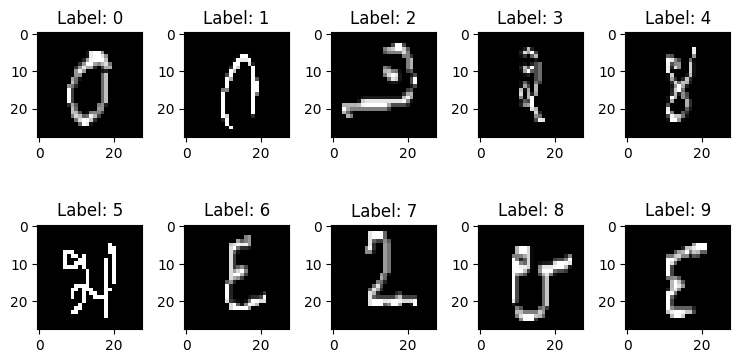

In [47]:
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainlab[i]))
plt.tight_layout()
plt.show()

Try to encode data:

In [48]:
autoencoder=tf.keras.Sequential()
autoencoder.add(tf.keras.layers.Dense(784, activation='relu'))
autoencoder.add(tf.keras.layers.Dense(512, activation='relu'))
autoencoder.add(tf.keras.layers.Dense(256,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(128,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(64,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(32,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(16,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(10,  activation='linear',name='XGB'))
autoencoder.add(tf.keras.layers.Dense(16,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(32,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(64,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(128,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(256,  activation='relu'))
autoencoder.add(tf.keras.layers.Dense(512, activation='relu'))
autoencoder.add(tf.keras.layers.Dense(784, activation='sigmoid', name='CLEAN'))

In [49]:
train=train.reshape(60000,28*28)
test=test.reshape(5000,28*28)

In [51]:


batch=1024
numepochs=101 #run
early = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("/content/autoencode.hdf5", monitor='mean_squared_error', verbose=0,
    save_best_only=True, mode='auto')

with tf.device('/GPU:0'):  #Use the GPU
    autoencoder.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])
    history = autoencoder.fit(train,train,validation_split=0.2,shuffle=True, epochs=numepochs,
                       batch_size=batch,callbacks=[early,checkpoint], verbose=2)



Epoch 1/101
47/47 - 9s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0746 - val_mean_squared_error: 0.0746 - 9s/epoch - 187ms/step
Epoch 2/101
47/47 - 6s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - 6s/epoch - 131ms/step
Epoch 3/101
47/47 - 7s - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - 7s/epoch - 150ms/step
Epoch 4/101
47/47 - 6s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - 6s/epoch - 132ms/step
Epoch 5/101
47/47 - 7s - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 7s/epoch - 150ms/step
Epoch 6/101
47/47 - 6s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - 6s/epoch - 137ms/step
Epoch 7/101
47/47 - 7s - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - 7s/epoch - 150ms/step

In [53]:

#Get the N x 10 data for passing to XGB
encoder=Model(autoencoder.input, autoencoder.get_layer('XGB').output)
#encoder.summary()  #This shows that we have captured the network from input to the XGB layer only.
#Encode Data..we might use this for classification rather than the original data
encoded_data = encoder.predict(train)  # For XGB (bottleeneck)
#Reconstructed Data
decoded_output = autoencoder.predict(train)        # reconstruction


1875/1875 [==============================] - 7s 4ms/step


In [54]:

#For decoder...We subtract out the initial layers to leave us with only the decoder
encoded_input = Input(shape=(10,))
decoder = autoencoder.layers[-7](encoded_input)
decoder = autoencoder.layers[-6](decoder)
decoder = autoencoder.layers[-5](decoder)
decoder = autoencoder.layers[-4](decoder)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)
#decoder.summary()  This shows that we have done it right.


1875/1875 [==============================] - 7s 4ms/step


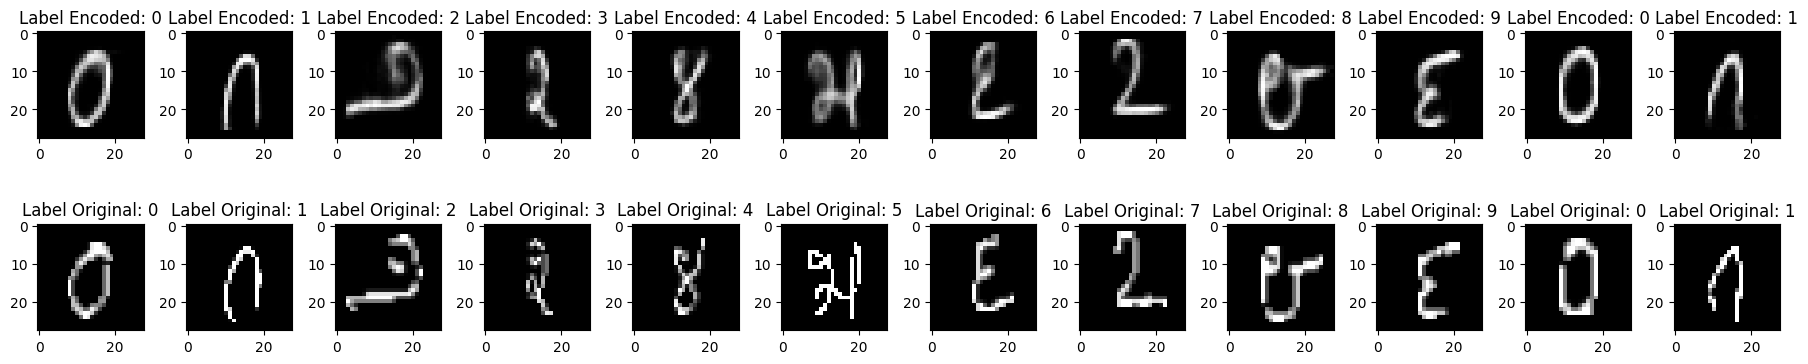

(60000, 784)


In [55]:

num_row = 2
num_col = 12 # plot images
#decoded=decoded_output.reshape(42000,28,28)
decoded=autoencoder.predict(train).reshape(60000,28,28)
newtrain=train.reshape(60000,28,28)
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_col):
    ax = axes[0, i%num_col]
    ax.imshow(decoded[i], cmap='gray')
    ax.set_title('Label Encoded: {}'.format(trainlab[i]))
for i in range(num_col):
    ax = axes[1, i%num_col]
    ax.imshow(newtrain[i], cmap='gray')
    ax.set_title('Label Original: {}'.format(trainlab[i]))
plt.tight_layout()
plt.show()
decoded=decoded.reshape(60000,28*28)
print(decoded.shape)

Create the model (used the same as discussion 2 since it was 99%)

In [57]:
model=Sequential()

model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Compile model

In [58]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

re shape data after encode

In [59]:
train.shape

(60000, 784)

In [61]:
train=train.reshape(60000,28,28)
test=test.reshape(5000,28,28)

In [63]:
decoded.shape

(60000, 784)

In [64]:
decoded=decoded.reshape(60000,28,28)

fit model

In [68]:
model.fit(train, trainlab,epochs=100)

Epoch 1/100
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0735 - accuracy: 0.9789
Epoch 2/100
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0617 - accuracy: 0.9823
Epoch 3/100
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0501 - accuracy: 0.9851
Epoch 4/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0497 - accuracy: 0.9852
Epoch 5/100
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0455 - accuracy: 0.9865
Epoch 6/100
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0447 - accuracy: 0.9865
Epoch 7/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0444 - accuracy: 0.9871
Epoch 8/100
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0455 - accuracy: 0.9869
Epoch 9/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0442 - accuracy: 0.9870
Epoch 10/100
1875/1875 [==============================]

In [69]:

y_pred = model.predict(test)
y_predict = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

157/157 [==============================] - 1s 5ms/step


cross tab

In [97]:
pred1=tf.argmax(model.predict(train),1)
pd.crosstab(trainlab, pred1, margins=True)

1875/1875 [==============================] - 12s 6ms/step


col_0,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
0,5963,37,0,0,0,0,0,0,0,0,6000
1,14,5986,0,0,0,0,0,0,0,0,6000
2,7,0,5992,0,1,0,0,0,0,0,6000
3,0,0,0,5987,0,0,0,13,0,0,6000
4,0,0,0,0,5999,1,0,0,0,0,6000
5,0,0,0,0,0,6000,0,0,0,0,6000
6,0,0,0,0,0,1,5985,12,0,2,6000
7,1,0,0,2,0,0,0,5997,0,0,6000
8,0,0,0,0,0,0,0,0,6000,0,6000


accuracy

In [71]:
sum(np.diagonal(pd.crosstab(trainlab,pred1)))/60000

0.9981

create submission data

In [108]:
submission = pd.read_csv('/content/drive/MyDrive/Mnist/sample_submission.csv')

In [81]:
submission

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
...,...,...
4995,4995,5
4996,4996,5
4997,4997,5
4998,4998,5


In [87]:
submission['label'] = y_predict

In [88]:
submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [94]:
submission.to_csv("submission.csv",index=False)

In [112]:
train=train.drop(columns=['label'])

tray encode data

In [113]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

forxgboost=Model(autoencoder.input, autoencoder.get_layer('XGB').output)
encoded_data = forxgboost.predict(train)
encoded_data.shape

1875/1875 [==============================] - 6s 3ms/step


(60000, 10)

In [115]:


xgbc = xgb.XGBClassifier(use_label_encoder=False, verbosity=0, max_depth=6, learning_rate=.3, n_estimators=300)
myxgbfit=xgbc.fit(encoder.predict(train),trainlab)



1875/1875 [==============================] - 6s 3ms/step


In [116]:
myxgbfit.score(encoded_data, trainlab)

1.0

In [117]:
pred2=tf.argmax(encoded_data,1)
pd.crosstab(trainlab, pred2, margins=True)

col_0,0,2,3,4,5,7,8,9,All
label,,,,,,,,,
0,8,28,0,3166,225,1,714,1858,6000
1,7,52,0,474,1,0,1722,3744,6000
2,1591,3096,0,58,4,0,6,1245,6000
3,5807,8,0,79,0,62,31,13,6000
4,233,0,0,126,0,1369,4261,11,6000
5,3306,3,0,65,1,268,248,2109,6000
6,4256,8,0,23,0,1685,28,0,6000
7,3701,1,0,111,0,2127,55,5,6000
8,22,192,1,486,191,54,33,5021,6000


In [118]:
sum(np.diagonal(pd.crosstab(trainlab,pred2)))/42000

0.010476190476190476

worst result use without it
